In [1]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from scipy.integrate import odeint 
import scipy.signal as signal 
from scipy.spatial import KDTree


import pickle 
from numpy import random
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  
import os 
import os.path 

from SALib.sample import saltelli, fast_sampler, latin
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris, delta
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import glob 
from pathlib import Path
import shutil
from numba import njit, typed
import subprocess
import stat
import sys

In [7]:
'''
The deterministic model of biological oscillator
''' 
#@experimental.jitclass
class Oscillator: 
	def __init__(self, parameter_values, params, initial_conditions, dt = 0.1, mode = 1, sigma = 0.001, volume = 0.5): 
		self.nParams = len(params)   
		self.params = params #model parameters
		self.parameter_values = parameter_values #allowed parameter ranges  
		self.y0 = initial_conditions 
		self.volume = volume
		self.copynumbers = [self.copynumber(x) for x in self.y0]	
		self.dt = dt
		self.sigma = sigma
		self.T = 20 
		self.N = int(self.T/self.dt) 
		self.ts = np.linspace(0, self.T, self.N) 
		self.amp = 300 #[nM] 		
		self.per = self.T/8 	
		self.sample_rate 		= 0.0033333333 #Hz 
		self.samples_per_hour 	= (1/self.dt)		
		self.jump 				= int(self.samples_per_hour/(self.sample_rate*3600)) if int(self.samples_per_hour/(self.sample_rate*3600)) else 1 	 	
		self.ideal = self.amp*(np.sin(math.pi*(self.ts)/self.per - math.pi/2) + 1) 
		#number of samples for FFT		
		self.nS = self.N/self.jump 
		self.dF = self.sample_rate/self.nS  
		self.idealF = self.getFrequencies(self.ideal) 
		self.idealFreq = 0.3 #peaks per second 	
		self.penalty = 0.5 	
		thresholdOne = -(self.nS/2)*100 #10nM -+ from ideal signal harmonics       
		thresholdTwo = 0.1
		thresholdThree = 0.1
		#self.maxFreq = 0.5
		#self.maxPeaks = self.maxFreq * self.T  
		self.minAmp = 1
		self.maxAmp = 6000 
		self.mode = mode    			
		self.modes = [self.eval]       
		self.threshold = thresholdOne  
		self.omega = 1000 #nm^-1 
		if self.mode == 1:
			self.threshold = thresholdTwo
		elif self.mode == 2:
			self.threshold = thresholdThree
	
	#gets summed difference of arrayData
	@staticmethod 	
	def getDif(indexes, arrayData):	
		arrLen = len(indexes)
		sum = 0
		for i, ind in enumerate(indexes):
			if i == arrLen - 1:
				break
			sum += arrayData[ind] - arrayData[indexes[i + 1]]
			
		#add last peak - same as substracting it from zero 
		sum += arrayData[indexes[-1:]]  
		return sum   
		
	#gets standard deviation 
	@staticmethod 
	def getSTD(indexes, arrayData, window):
		numPeaks = len(indexes)
		arrLen = len(arrayData)
		sum = 0
		for ind in indexes:
			minInd = max(0, ind - window)
			maxInd = min(arrLen, ind + window)
			sum += np.std(arrayData[minInd:maxInd])  
			
		sum = sum/numPeaks 	
		return sum	 
	
	def getFrequencies(self, y):
		#fft sample rate: 1 sample per 5 minutes
		y = y[0::self.jump]  
		res = abs(fft.rfft(y))
		#normalize the amplitudes 
		res = res/math.ceil(self.nS/2) 
		return res

	def costOne(self, Y): 
		p1 = Y[:,1]   
		fftData = self.getFrequencies(p1)     
		
		diff = fftData - self.idealF         
		cost = -np.dot(diff, diff) 		
		return cost,	
		
	def costTwo(self, Y, getAmplitude = False): 
		p1 = Y[:,-1] 
		fftData = self.getFrequencies(p1)      
		fftData = np.array(fftData) 
		
		#find peaks using very low threshold and minimum distance
		#indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1) 
		#find number of peaks in time domain for frequency threshold
		#peaknumber = len(peakutils.indexes(p1, thres=0.02/max(fftData), min_dist=1))  

		indexes = peakutils.indexes(fftData, thres=np.mean(fftData), min_dist=10, thres_abs = True) 
		#find number of peaks in time domain for frequency threshold
		peaknumber = len(peakutils.indexes(p1, thres=np.mean(p1), min_dist=1, thres_abs = True)) 

		#in case of no oscillations return 0 
		if len(indexes) == 0 or peaknumber == 0:
			return 0 , 0 
		#if amplitude is greater than 400nM
		amp = np.max(fftData[indexes])
		if amp > self.maxAmp: 
			return 0 ,0 
		fitSamples = fftData[indexes]  			
		std = self.getSTD(indexes, fftData, 1)  
		diff = self.getDif(indexes, fftData)  
		penalty =  ((abs(self.idealFreq - (peaknumber/self.T)))*self.penalty)
		cost = std + diff #- penalty #penalize difference from ideal frequency
		#print(cost)   
		if getAmplitude:
			return cost, amp
		return cost#, penalty

	def costYield(self, Y): #optimize for yield of trimer 
		if max(Y[:,-1]) < sum(self.y0):
			return Y[1:round(len(Y[:,-1])/2),-1], 0 #return mid
		else:
			return Y[1,1], 0
		
	def isViableFitness(self, fit):
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval(point)  
		# if self.mode == 0:
		# 	return self.isViableFitness(fitness[0]) 
			
		fit = fitness[0]

		# amp = 0
		# if fit > 0:
		# 	amp = fitness[1] 
		return self.isViableFitness(fit) #and amp >= self.minAmp and amp <= self.maxAmp   


		
	#evaluates a candidate  
	def eval(self, candidate, getAmplitude = True): 
		Y = np.array(self.simulate(candidate)) 
		if self.mode == 0:
			return self.costOne(Y)  
		elif self.mode == 1:
			return self.costTwo(Y, getAmplitude)   #False before 7-26  
		else:
			return self.costYield(Y)

	
	#simulates a candidate
	def simulate(self, candidate):
		# y0 =  [candidate[0],candidate[1],candidate[2],candidate[3],0,candidate[4],0,0,0,0,0,0]
		return odeint(self.oscillatorModelOde, self.y0, self.ts, args=(typed.List(candidate),))   	

		

	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = np.linspace(0, self.T, self.N)
			solutions = self.simulate(subject) 			
		else:
			#ssa simulation
			# can = self.full_converter(subject, True)
			t,solutions = self.ssa(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)


		plt.plot(t,solutions[:,0], color="b", label = 'geneA')
		plt.plot(t,solutions[:,1], color="orange", label = 'mRNA_A')
		plt.plot(t,solutions[:,2], color="gold", label = 'A')
		#plt.plot(t,solutions[:,3], color="r", label = 'P')
		#plt.plot(t,solutions[:,4], color="cyan", label = 'LK')
		plt.plot(t,solutions[:,5], color="r", label = 'geneR')
		# plt.plot(t,solutions[:,6], color="g", label = 'PIP2-AP2')
		#plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
		#plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
		#plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
		#plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')
		#plt.plot(t,solutions[:,11], color="purple", label = 'LpP')
		# plt.plot(t,solutions[:,13], color = "cyan", label = 'PIP2-AP2-TfR')
		# plt.plot(t,solutions[:,-3], color = "violet", label = 'XBCD')

		plt.xlabel('Time (s)')
		plt.ylabel('Concentration (uM)')
		plt.legend(loc = 'upper left', bbox_to_anchor = (1.02,1)) #prop={'size': 6}
		plt.show()
			 				
	def getTotalVolume(self):
		vol = 1.0
		for param in self.params:		
			vol = vol*(self.parameter_values[param]["max"] - self.parameter_values[param]["min"])
		return vol 

	@staticmethod
	@njit
	def oscillatorModelOde(Y, t, can): 

		#parameters [kf1, kf2, kb2, kf3, kf4, kf5, kb5, kf6, kf7, kf8, kf9, kf10, kf11, kf12, kf13, kf14]
		kf1 = can[0]
		kf2 = can[1]
		kb2 = can[2]
		kf3 = can[3]
		kf4 = can[4]
		kf5 = can[5]
		kb5 = can[6]
		kf6 = can[7]
		kf7 = can[8]
		kf8 = can[9]
		kf9 = can[10]
		kf10 = can[11]
		kf11 = can[12]
		kf12 = can[13]
		kf13 = can[14]
		kf14 = can[15]
	
		#initial conditions
		geneA = Y[0]   # make sure in uM
		mRNA_A = Y[1]
		A = Y[2]
		geneA_bound = Y[3]
		geneR = Y[4] 
		mRNA_R = Y[5]
		geneR_bound = Y[6] 
		R = Y[7] 
		C = Y[8] 

		dgeneA = kb2*geneA_bound - kf2*A*geneA  
		dmRNA_A = kf1*geneA + kf3*geneA_bound - kf13*mRNA_A
		dA = kb2*geneA_bound + kb5*geneR_bound + kf7*mRNA_A - kf11*A - kf2*A*geneA - kf5*A*geneR - kf9*A*R
		dgeneA_bound = kf2*A*geneA - kb2*geneA_bound
		dgeneR = -kf4*geneR
		dmRNA_R = kf6*geneR_bound + 2*kf4*geneR - kf14*mRNA_R
		dgeneR_bound = kf5*A*geneR - kb5*geneR_bound
		dR = kf10*C + kf8*mRNA_R - kf12*R - kf9*A*R
		dC = kf9*A*R - kf10*C

		return([dgeneA, dmRNA_A, dA, dgeneA_bound, dgeneR, dmRNA_R, dgeneR_bound, dR, dC])	
	
	def getPerAmp(self, *args, mode="ode", indx=0): 
		if mode == "ode":
			ts = np.linspace(0, self.T, self.N*100) 
			if len(args) == 1:
				subject = args[0]
				Y = self.simulate(subject)  
			else:
				initials = args[0]
				params = args[1]
				Y = self.simulate_fixedparams(initials,params)				
		#else:
			#ts,Y = self.represilatorStochastic(subject) 
		
		ts = np.array(ts) 
		Y = np.array(Y) 
		sig = Y[:, indx]
		# indx_max, properties = signal.find_peaks(sig, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)      #old code 
		# indx_min, properties = signal.find_peaks(sig*-1, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)  

		indx_max = peakutils.indexes(sig, thres=0.5, min_dist=1)
		indx_min = peakutils.indexes(sig*-1, thres=0.5, min_dist=1)   

		amps = [] 
		pers = []   
		for i in range(min(len(indx_max), len(indx_min))):
			amps.append((sig[indx_max[i]] - sig[indx_min[i]])/2) 			
			if i + 1 < len(indx_max):
				pers.append(ts[indx_max[i + 1]] - ts[indx_max[i]])
			if i + 1 < len(indx_min):
				pers.append(ts[indx_min[i + 1]] - ts[indx_min[i]])
		
		if len(amps) > 0 and len(pers) > 0:
			amps = np.array(amps)   	
			pers = np.array(pers)  
			
			#print(amps)
			amp = np.mean(amps)	
			#print(pers) 
			per = np.mean(pers) 
		else:
			amp = 0
			per = 0  
		
		#print("amp" + str(amp)) 
		#print("per" + str(per))   	
		
		return per, amp 

	#@njit
	def ssa(self, candidate):
		#omega = self.omega
		#y0 = [can[13],0,can[14],can[15],0,can[16],0,0,0,0,0,0]
		#y0 = [self.copynumber(i) for i in self.y0]

		# y0 = [candidate[0],candidate[1],candidate[2],candidate[3],0,candidate[4],0,0,0,0,0,0]
		# copynumbers = [self.copynumber(x) for x in candidate]

		y_conc = np.array(self.copynumbers).astype(int) 
		Y_total = []
		Y_total.append(y_conc)
		t = 0 
		t_end = 100
		T = []   
		T.append(t)
		
		can = candidate
		#get kinetic rates 
		y = can[12]
		
		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]*y
		kb5 = can[10]
		kcat5 = can[11]

		ka6 = can[0]*y
		kb6 = can[1]
		kcat6 = can[2]

		ka8 = can[13]
		kb8 = can[14]
		
		N = np.zeros((20,14)) #6 species, 15 reactions
		#L+K -> LK
		N[0,0] = -1 
		N[0,2] = -1 
		N[0,4] = 1

		#LK -> L+K
		N[1,0] = 1
		N[1,2] = 1
		N[1,4] = -1

		#LK -> Lp+K
		N[2,4] = -1
		N[2,1] = 1
		N[2,2] = 1

		#Lp+A -> LpA
		N[3,1] = -1
		N[3,5] = -1
		N[3,6] = 1

		#LpA -> Lp+A
		N[4,1] = 1
		N[4,5] = 1
		N[4,6] = -1
		
		#LpA + K -> LpAK
		N[5,6] = -1 
		N[5,2] = -1
		N[5,7] = 1

		#LpAK -> LpA + K
		N[6,6] = 1
		N[6,2] = 1
		N[6,7] = -1 
		
		#L + LpAK -> LpAKL
		N[7,0] = -1
		N[7,7] = -1
		N[7,10] = 1

		#LpAKL -> L + LpAK
		N[8,0] = 1
		N[8,7] = 1
		N[8,10] = -1

		#LpAKL -> Lp + LpAK
		N[9,10] = -1
		N[9,1] = 1
		N[9,7] = 1

		#Lp + P -> LpP
		N[10,1] = -1
		N[10,3] = -1
		N[10,11] = 1

		#LpP -> Lp + P
		N[11,1] = 1
		N[11,3] = 1
		N[11,11] = -1

		#LpP -> L + P
		N[12,11] = -1
		N[12,0] = 1
		N[12,3] = 1

		#LpA + P -> LpAP
		N[13,6] = -1
		N[13,3] = -1
		N[13,8] = 1

		#LpA + P <- LpAP
		N[14,6] = 1
		N[14,3] = 1
		N[14,8] = -1

		#Lp + LpAP -> LpAPLp
		N[15,1] = -1
		N[15,8] = -1
		N[15,9] = 1

		#Lp + LpAP <- LpAPLp
		N[16,1] = 1
		N[16,8] = 1
		N[16,9] = -1

		#LpAPLp -> L + LpAP
		N[17,9] = -1
		N[17,0] = 1
		N[17,8] = 1 

		#LpA + T -> LpAT 
		N[18,6] = -1
		N[18,12] = -1
		N[18,13] = 1

		#LpA + T <- LpAT 
		N[19,6] = 1
		N[19,12] = 1
		N[19,13] = -1
		
		while t < t_end:
			#choose two random numbers 
			r = np.random.uniform(size=2)
			r1 = r[0] 
			r2 = r[1] 					
			
			#get propensities
			a = np.zeros(len(N))
			a[0] = ka1*y_conc[0]*y_conc[2] 
			a[1] = kb1*y_conc[4]
			a[2] = kcat1*y_conc[4]  
			
			a[3] = ka2*y_conc[1]*y_conc[5] 
			a[4] = kb2*y_conc[6]

			a[5] = ka3*y_conc[6]*y_conc[2]
			a[6] = kb3*y_conc[7]

			a[7] = ka6*y_conc[0]*y_conc[7]
			a[8] = kb6*y_conc[10]
			a[9] = kcat6*y_conc[10]

			a[10] = ka7*y_conc[1]*y_conc[3]
			a[11] = kb7*y_conc[11]
			a[12] = kcat7*y_conc[11]

			a[13] = ka4*y_conc[6]*y_conc[3]
			a[14] = kb4*y_conc[8]

			a[15] = ka5*y_conc[1]*y_conc[8]
			a[16] = kb5*y_conc[9]
			a[17] = kcat5*y_conc[9]  

			a[18] = ka8*y_conc[6]*y_conc[12]
			a[19] = kb8*y_conc[13]
			
			asum = np.cumsum(a)
			a0 = np.sum(a)  
			#get tau
			tau = (1.0/a0)*np.log(1.0/r1)     
		
			#select reaction 
			reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element			
		
			#update concentrations
			y_conc = y_conc + N[reaction_number,:]   	
			Y_total.append(y_conc) 
			#update time
			t = t + tau  
			T.append(t)
		T = np.array(T) 
		deconvert = np.vectorize(self.concentration)
		Y_total = np.array(Y_total) 
		return T, deconvert(Y_total) 

	def copynumber(self, conc):
		volume = self.volume/1e15 #converts liters to um^3
		conc = conc/1e6 #converts umol to mol
		moles = conc * volume #volume must be passed in um^-3
		copies = moles * 6.023e23
		return copies

	def concentration(self, copies):
		moles = copies/6.023e23
		volume = self.volume/1e15
		conc = moles/volume 
		return conc*1e6

	def rate_converter(self, rate, ode = False):
		#convert ka in (uM*s)^-1 to nm^3/us
		if ode == True:
			rate1 = rate/0.602214076 ##conversion ratio from page 10 of NERDSS manual
			rate2 = rate1*1e6 ##convert from us to s
			volume = self.volume*1e9 #convert volume to nm3
			return rate2/volume ##calculate copy numbers per second
		else: #else kb or kcat in s^-1
			#new_rate = rate / 1e6 #convert per second to per microsecond
			return rate/0.602214076 

	def full_converter(self, sample, ode = False):
		new_sample = []
		for i,val in enumerate(sample): 
			if i == 0 or i ==3 or i ==5 or i==7 or i==9 or i==13:
				new_sample.append(self.rate_converter(val, ode))
			elif i==1 or i==2 or i==4 or i==6 or i==8 or i==10 or i==11 or i==14:
				new_sample.append(val)
			elif i==12 and ode==True:
				new_sample.append(val/(2*self.sigma))
			else:
				new_sample.append(val)
		# new_sample.extend(self.copynumbers)
			
		return new_sample
	

In [3]:
'''
Regions consist of cloud of points and principal component that govern the direction of exploration  
''' 
class Region: 
	def __init__(self, points, model, label, depth=1):    
		self.points = np.array(points)  
		self.model = model  
		self.pca = PCA(n_components=self.model.nParams)
		self.components = None
		self.prevComponents = None 
		self.cluster = False
		self.terminated = False  
		self.iter = 0      
		self.maxIter = 10            
		self.threshold = 0.001    
		self.label = label
		self.maxVarScale = 4
		self.minVarScale = 2   
		self.varScaleDt = (self.maxVarScale - self.minVarScale)/(float(self.maxIter))    		     		
		self.varScale = self.maxVarScale         
		self.depth = depth  
		
	def updateVariance(self): 
		self.varScale = self.varScale - self.varScaleDt

	def updateIter(self):
		self.iter = self.iter + 1
		self.updateVariance()          	
		
	def fitPCA(self): 
		self.prevComponents = self.components 
		self.pca.fit(self.points)
		self.components = self.pca.components_
	
	def transform(self, points):  
		return self.pca.transform(points)  
		
	def inverse_transform(self, points):
		return self.pca.inverse_transform(points)   
		
	def converged(self):
		if self.components is None or self.prevComponents is None: 
			return False		
		return np.linalg.norm(self.components - self.prevComponents) < self.threshold   
		
	def explored(self):    
		return self.terminated or self.iter > self.maxIter or self.converged()   

In [9]:
'''
The main class
'''
from genericpath import isdir


class Solver:
	def __init__(self, model, name, populationSize=10000, NGEN = 10, nsamples = 1e5, writeparms = False, verbose=True, auto = False):                                                      
		self.model = model 
		self.name = name           
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.9 #from 0.75    
		#self.copynumbers = [self.copynumber(x) for x in model.y0]
		self.centerpoints = {}	
		self.writeparms = writeparms
		self.verbose = verbose
		self.auto = auto 
		self.num_jobs = 0
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#### functions for printing NERDSS parameters ####
	def waterbox(self,VA):
		V = self.model.volume * 1e9 #convert um3 to nm3
		VA = VA * 1000 #convert um to nm 

		A = V/VA #units of nm2
		x = round(np.sqrt(A))
		y = round(np.sqrt(A))
		z = round(VA) 

		dimensions = [x,y,z]
		#ztest = z/10
		#xtest = np.sqrt(V/ztest)
		#ytest = np.sqrt(V/ztest)

		#test = (ztest*xtest*ytest)/(xtest*ytest)

		return dimensions

	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		
		for evalMode in self.model.modes: 
			nominalValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring): 
					if self.model.isViable(ind) and ind not in nominalValsMode:  
						nominalValsMode.append(ind)      
					ind.fitness.values = fit     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				print(rdm_ind)
				# rdm_ind_label = {}

				# for parameter, value in zip(self.model.parameter_values.keys(), rdm_ind):
				# 	rdm_ind_label[parameter] = value


				# #print(rdm_ind_label)

				# kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka7':rdm_ind[9]}
				# kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb7':rdm_ind[10]}
				# kcatdic = {'kcat1':rdm_ind[2],'kcat7':rdm_ind[11]}
				# KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km7':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
				# comparison_list = [kadic,kbdic,kcatdic,KDdic]

				# for h in comparison_list:
				# 	#sorted_dict = {}
				# 	sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]

				# 	string = str()
				# 	for i in range(len(sorted_keys)):
				# 		string += sorted_keys[i] + " < "
				# 	if self.verbose:
				# 		print(string)
				
				# #calculate waterbox dimensions for NERDSS
				# waterbox = self.waterbox(rdm_ind[12])

				# #convert parameters for NERDSS
				# NERDSSparamlist = []
				# parmslist = []
				# ODElist = []
				# for param in rdm_ind_label.items():
				# 	if 'ka' in param[0]:
				# 		converted_rate = self.model.rate_converter(param[1])
				# 		NERDSSparamlist.append(param[0] + ': ' + str(converted_rate) + ' nm^3/us')
				# 		parmslist.append(str(converted_rate))
				# 		converted_rate_ode = self.model.rate_converter(param[1],True)
				# 		ODElist.append(converted_rate_ode)
				# 	elif 'kb' in param[0] or 'kcat' in param[0]:
				# 		#converted_rate = self.rate_converter(param[1], ka = False)
				# 		NERDSSparamlist.append(param[0] + ': ' + str(param[1]) + ' s^-1')
				# 		parmslist.append(str(param[1]))
				# 		ODElist.append(param[1])
				# 	elif 'VA' in param[0]:
				# 		gamma = param[1]/(2*self.model.sigma)
				# 		ODElist.append(gamma)

				# NERDSSparamlist.append('sigma: ' + str((self.model.sigma)*1e3))
				# ODElist.extend(self.model.copynumbers)
				# # OGparamlist = rdm_ind.extend(self.model.y0)

				# #write parms 
				# if self.writeparms == True:
				# 	self.write_parms(parmslist, waterbox, gen, os.getcwd())

				# #print parameters 
				# if self.verbose:
				# 	print('Original parameters with concentration units:' + '\n')
				# 	print(rdm_ind_label)
					
				# 	print('\n'+ 'NERDSS parameters' + '\n')
				# 	print(NERDSSparamlist)

				# 	print('\n'+ 'Waterbox dimensions' + '\n')
				# 	print(waterbox)

				# 	print('\n' + 'ODE test parameters' + '\n')
				# 	print(ODElist)

				# 	print("Number of viable points: " + str(len(nominalValsMode))) 

				# 	print(self.model.isViable(rdm_ind))
					
				# 	cost, penalty = self.model.eval(rdm_ind)
				# 	print('Cost: ' + str(cost))
				# 	try:
				# 		print('Frequency penalty: ' + str(penalty))
				# 	except IndexError:
				# 		pass 
				self.model.plotModel(rdm_ind)
				# self.model.plotModel(rdm_ind, lipid = False)

				# self.model.plotModel(rdm_ind,mode="ssa")

			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
		return nominalVals        


	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams): 
			#try:
				#candidate.append(loguniform.rvs(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
			#except ValueError:
			candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"] or candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd <= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"]: 
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["min"]  
				if candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]:  
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		i = 0
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable 
			if self.model.isViable(point): 
				viable.append(point)   		
		return viable          
	
	# gap statistic method
	# returns the optimal number of clusters 	
	def gapStatistic(self, region, number_ref = 10, max_clusters = 2, plot = False):        
		#sample size is equal to the number of samples in gaussian sampling  
		sample_size = self.nsamples    
		subjects = np.array(region.points)                 
		gaps = []
		deviations = []   
		references = [] 
		clusters_range = range(1, max_clusters + 1) 
		
		transformed = region.transform(subjects) 
		#get min and max parameter values in pca space 
		minP = np.min(transformed, axis=0)  
		maxP = np.max(transformed, axis=0)   
		
		for gap_clusters in clusters_range:
			print(gap_clusters) 
			reference_inertia = []	
			for index in range(number_ref): 

				#OBB ... orientated bounding box 
				#random sampling within the PCA bounding box			
				reference = minP + random.rand(sample_size, self.model.nParams)*(maxP - minP)
				reference = region.inverse_transform(reference) 
				
				kmeanModel = KMeans(gap_clusters) 
				kmeanModel.fit(reference) 
				reference_inertia.append(kmeanModel.inertia_)    
			
			kmeanModel = KMeans(gap_clusters)      
			kmeanModel.fit(subjects)     
			log_ref_inertia = np.log(reference_inertia)	 
			#calculate gap
			gap = np.mean(log_ref_inertia) - np.log(kmeanModel.inertia_)  
			sk = math.sqrt(1 + 1.0/number_ref)*np.std(log_ref_inertia)  
			gaps.append(gap)    
			deviations.append(sk)        			
			
		# Plot the gaps   		
		if plot:
			plt.clf() 
			ax = plt.gca() 
			ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))	 
			ax.xaxis.set_major_locator(ticker.MultipleLocator(2))	
			lines = plt.errorbar(clusters_range, gaps, ecolor='dodgerblue', yerr=deviations, fmt='-', color='dodgerblue') 
			plt.setp(lines[0], linewidth=1.5)  
			plt.ylabel('Gaps')
			plt.show()  
			
		#return optimal number of clusters
		for k in range(0, max_clusters - 1): 
			if gaps[k] >= gaps[k + 1] - deviations[k + 1]: 
				print("Optimal number of clusters: " + str(k + 1)) 
				return k + 1     
		print("Optimal number of clusters: " + str(max_clusters))    	
		return max_clusters   

	
	#returns the viable volume for 
	def getViableVolume(self, viableRegions, sample_size = int(1e4)):
		volume = 0 

		for region in viableRegions:		
			regPoints = region.points
			region.fitPCA() 						 						
			transformed = region.transform(regPoints) 
		  		
			minP = np.min(transformed, axis=0)   
			maxP = np.max(transformed, axis=0)   
		
			dP = maxP - minP
			volB = np.prod(dP)			

			mcRef = minP + random.rand(sample_size, self.model.nParams)*dP  
			mcRef = region.inverse_transform(mcRef)	 		
			
			viaPoints = self.getViablePoints(mcRef) 
			count = np.ma.size(viaPoints, axis=0) 
			
			#volume for region  
			ratio = count/sample_size   
			volume = volume + ratio*volB  			
	
		print("Bounding box volume " + str(volB)) 
		print("Volume " + str(volume))   
		print("Total volume " + str(self.model.getTotalVolume()))   		
		print("Volume ratio:" + str(volume/self.model.getTotalVolume())) 
		return volume 


	def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
		colorLen = len(colors) 

		for i in range(nRegions): 
			col = colors[i % colorLen] 		 
			plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
			plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
			plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
			plt.setp(bp['fliers'][i], color=col) 
			plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
		
	def plotParameterVariances(self, viableSets, names=None, units=None):      
		#go through all parameters  
		params = self.model.params    
		figure = plt.figure()     
		nRows = math.ceil(len(params)/3)    
		for pcount, param in enumerate(params):    
			ax1 = plt.subplot(nRows, 3, pcount+1)  
			#if names == None:
			#	ax1.set_title(str(param) + str(pcount))    
			#else:
			#	ax1.set_title(names[pcount])  
			if units != None:
				plt.ylabel(names[pcount] + " " + units[pcount])  
			allRegions = [] 	
			#go through all regions 
			numSets = len(viableSets) 
			allNames = []
			allBoxes = []
			for count, reg in enumerate(viableSets): 
				points = np.array(reg.points)    
				data = points[:,pcount]   
				allRegions.append(data)   
				allNames.append("Region " + str(count + 1))   				
			bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4) 
			self.setBoxColors(bp, numSets, ax1) 		
			allBoxes = bp['boxes'] 
			
		#draw legend 
		figure.legend(allBoxes, allNames, 'lower right')
		plt.show()     
		
	#Main method  
	def run(self, filename, maxDepth=0):    
		#filename is a file to which viable sets will be serialized
		if not os.path.isdir("ViableSets"):  
			os.mkdir("ViableSets")
		if not os.path.isdir("CandidateSets"): 
			os.mkdir("CandidateSets")
		if not os.path.isdir("PDFs"): 
			os.mkdir("PDFs")
		viablesets_filename = "./ViableSets/" + filename  

		#estimate the inital viable set 
		viablePoints = self.findNominalValues()         		                 		
		
		if not viablePoints: 
			print("No viable points found!")  
			return 
		
		#dump viable points to file  
		pickle.dump(viablePoints, open(viablesets_filename + "ViableSet_IterGA.p", "wb+"))   
		
		reg = Region(viablePoints, self.model, "0")   
		reg.fitPCA() 
		
		fpca = PCA(n_components=2)  		 		
		fpca.fit(reg.points)
				
		viableSets = list() 
		viableSets.append(reg)  		  		 
		converged = False 		
		iter = 0 
		
		while not converged: 
			converged = True 			 		 	 					  	 
			iter += 1 
			print("Iteration: " + str(iter))  	
			for set in viableSets:   				
				set.updateIter() 
				#if set not already explored  
				if not set.explored():
					setSize = len(set.points) 
					print("Label: " + set.label)   
					print("Iter: " + str(set.iter))  
					print("Variance scaling factor: " + str(set.varScale))    								
					converged = False   					
						  
					#sample with 0 mean and scaled variance of prinicpal components       
					candidateSet = random.multivariate_normal([0]*self.model.nParams, np.diag(set.pca.explained_variance_)*set.varScale, self.nsamples)				
					candidateSet = set.inverse_transform(candidateSet)      
								
					#check if parameter values are not out of range  		
					inBounds = list() 
					for cand in candidateSet: 				
						if not self.checkOutAllBounds(cand): 
							inBounds.append(cand)  
					inBounds = np.array(inBounds)   		
					candidateSet = inBounds   
					
					X = fpca.transform(set.points) 
					try:
						Y = fpca.transform(candidateSet) 
					except ValueError:
						continue 	 				
					fig = plt.figure(iter)  
					plt.clf()          
					plt.scatter(Y[:, 0], Y[:, 1], c="red", alpha=0.1, edgecolor='k', rasterized=True, label = "Candidate")  
					plt.scatter(X[:, 0], X[:, 1], c="cornflowerblue", alpha=0.8, edgecolor='k', rasterized=True, label = "Viable") 

					plt.xlabel('PC 1') 
					plt.ylabel('PC 2')  
					plt.title("Iteration"+str(set.iter))  
					plt.legend()
					plt.close(fig)
					plt.savefig("./PDFs/" + filename + "Set" + set.label + "Iter" + str(set.iter) + ".pdf")        	 
					#identify viable points  
					viablePoints = np.array(self.getViablePoints(candidateSet)) 
					
					#if viable set is smaller than number of parameters do not accept it
					print("Number of viable points: " + str(len(viablePoints)))   
					
					if len(viablePoints) <= setSize/10:   						 
						#cluster if not enough points obtained with sampling    
						print("Clustering, insufficient number of points")   
						set.terminated = True      
						set.cluster = True           
					else:
						pickle.dump(candidateSet, open("./CandidateSets/" + filename + "_Region" + str(set.label) + "CandidateSet_Iter" + str(set.iter) +  ".p", "wb+"))     
						pickle.dump(viablePoints, open(viablesets_filename + "_Region" + str(set.label) + "ViableSet_Iter" + str(set.iter) + ".p", "wb+"))  						
						set.points = viablePoints           
						set.fitPCA()     	 			
				#if set not already terminated, terminate it and cluster   
				elif not set.terminated:    
					set.terminated = True       
					set.cluster = True         					
						
			#clustering, check for new clusters        	            
			newViableSets = list()   
			for set in viableSets: 
				if set.cluster and (maxDepth == 0 or set.depth < maxDepth):   
					set.cluster = False    
					setLabel = set.label    
					setDepth = set.depth      
					#determine the optimal number of clusters
					print("Clustering set" + set.label)      
					k = self.gapStatistic(set)    
					if k > 1:     
						#cluster and divide sets based on clustering 
						#update the list of sets 
						converged = False   
						kmeans = KMeans(n_clusters=k)  
						labels = kmeans.fit_predict(set.points)   
						# centroids = kmeans.cluster_centers_      
						for i in range(k): 
							ind = np.where(labels == i)[0]  
							points = set.points[ind]
							reg = Region(points, self.model, setLabel + str(i), depth=setDepth+1)         
							reg.fitPCA()
							newViableSets.append(reg)       						 			
			#end of clustering					 
			viableSets.extend(newViableSets)     
		#end of while loop  

In [5]:
ka_min, ka_max = 0., 100.
kb_min, kb_max = 0., 500.
kcat_min, kcat_max = 0., 500.



param_values = {
            "kf1": {"min": ka_min, "max": ka_max},  
            "kf2": {"min": kb_min, "max": kb_max},             				        
            "kb2": {"min": ka_min, "max": ka_max},         
            "kf3": {"min": ka_min, "max": ka_max},         
            "kf4": {"min": ka_min, "max": ka_max}, 
            "kf5": {"min": ka_min, "max":ka_max}, 
            "kb5": {"min": kb_min, "max":kb_max},
            "kf6": {"min": ka_min, "max":ka_max},
            "kf7": {"min": ka_min, "max":ka_max},
            "kf8": {"min": ka_min, "max":ka_max},
            "kf9": {"min": ka_min, "max":ka_max},
            "kf10": {"min": ka_min, "max":ka_max},
            "kf11": {"min": ka_min, "max":ka_max},
            "kf12": {"min": ka_min, "max":ka_max},
            "kf13": {"min": ka_min, "max":ka_max},
            "kf14": {"min": ka_min, "max":ka_max},
            }   	

In [ ]:
varnames = ["L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP","T","X","B","C","D","XB","XC","XD","XBC","XXBC","XBD","XXBD","XCD","XXCD","XBCD","XXBCD","XXXBCD"]
initial_populations = np.append(np.array([0,3,0.2,0.3,0,3,0,0,0,0,0,0,2,1]),(np.zeros((29-14))))

initdict = {k:v for k,v in zip(varnames,initial_populations)}
initdict['B'] = 0.5
initdict['C'] = 0.5
initdict['D'] = 0.5
initdict['Lp'] = 3.
initdict['A'] = 0.9
initdict['T'] = 0.3
initvals = np.array(list(initdict.values()))
initdict

./FinalProj1


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[66.84787290615691, 217.8546102613964, 16.23278961155012, 86.17420313482118, 80.63602458672733, 54.05310247235237, 165.09552713978164, 100.0, 76.90091709497298, 29.928487971482824, 26.266176236009404, 100.0, 33.371887950155504, 57.323457139343425, 34.55194834296841, 24.569896224465047]


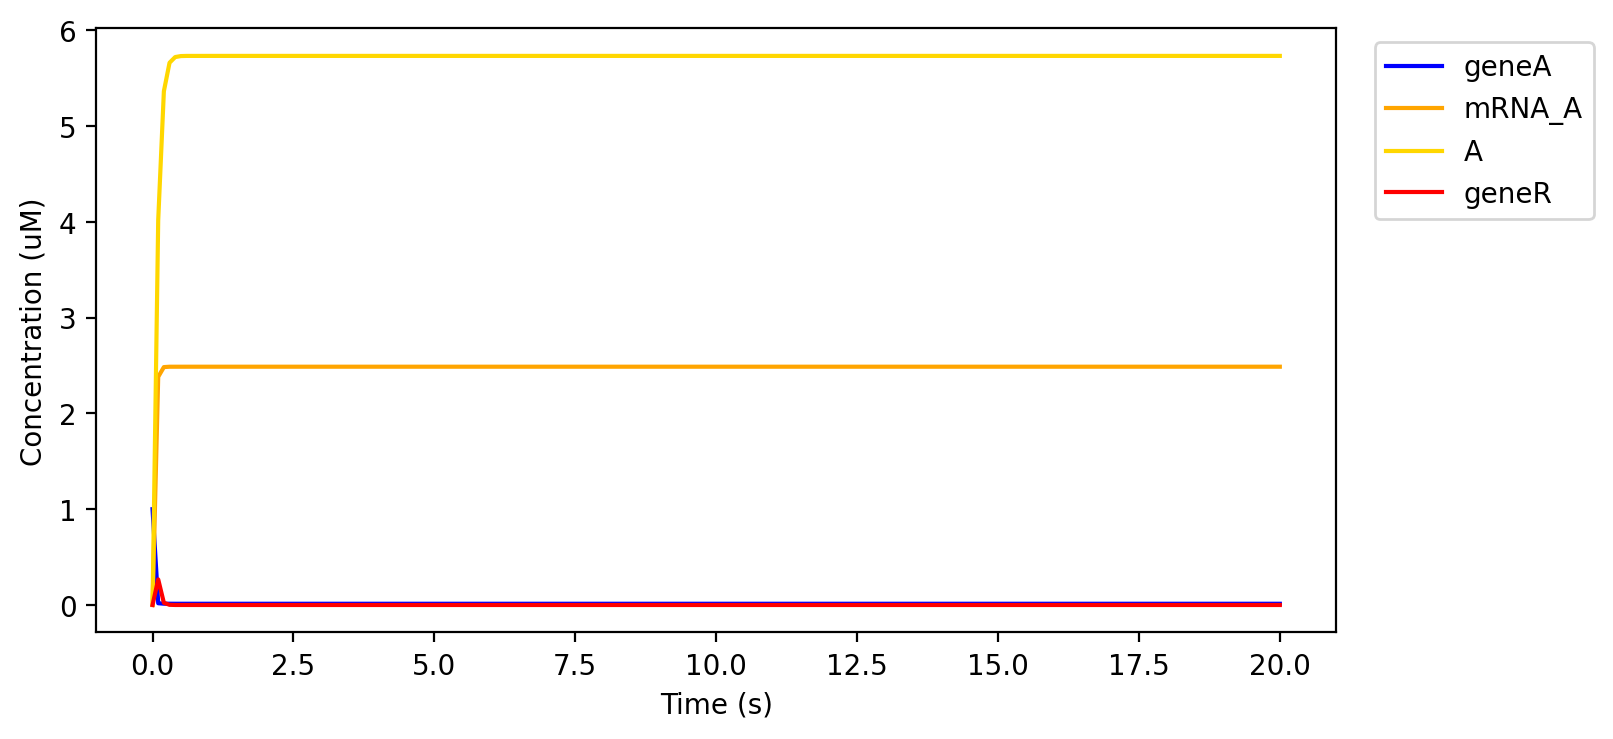

1


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.8591410894489666, 447.0077267600605, 68.34191533435795, 54.305685639029896, 0.2022806187198655, 1.4131573722676214, 98.16646974848987, 27.651953749171696, 12.100313849547568, 54.38078867269907, 45.967920004337785, 17.262571245343597, 1.1000623194976842, 2.384350321828082, 2.6914922475331577, 56.507272242258644]


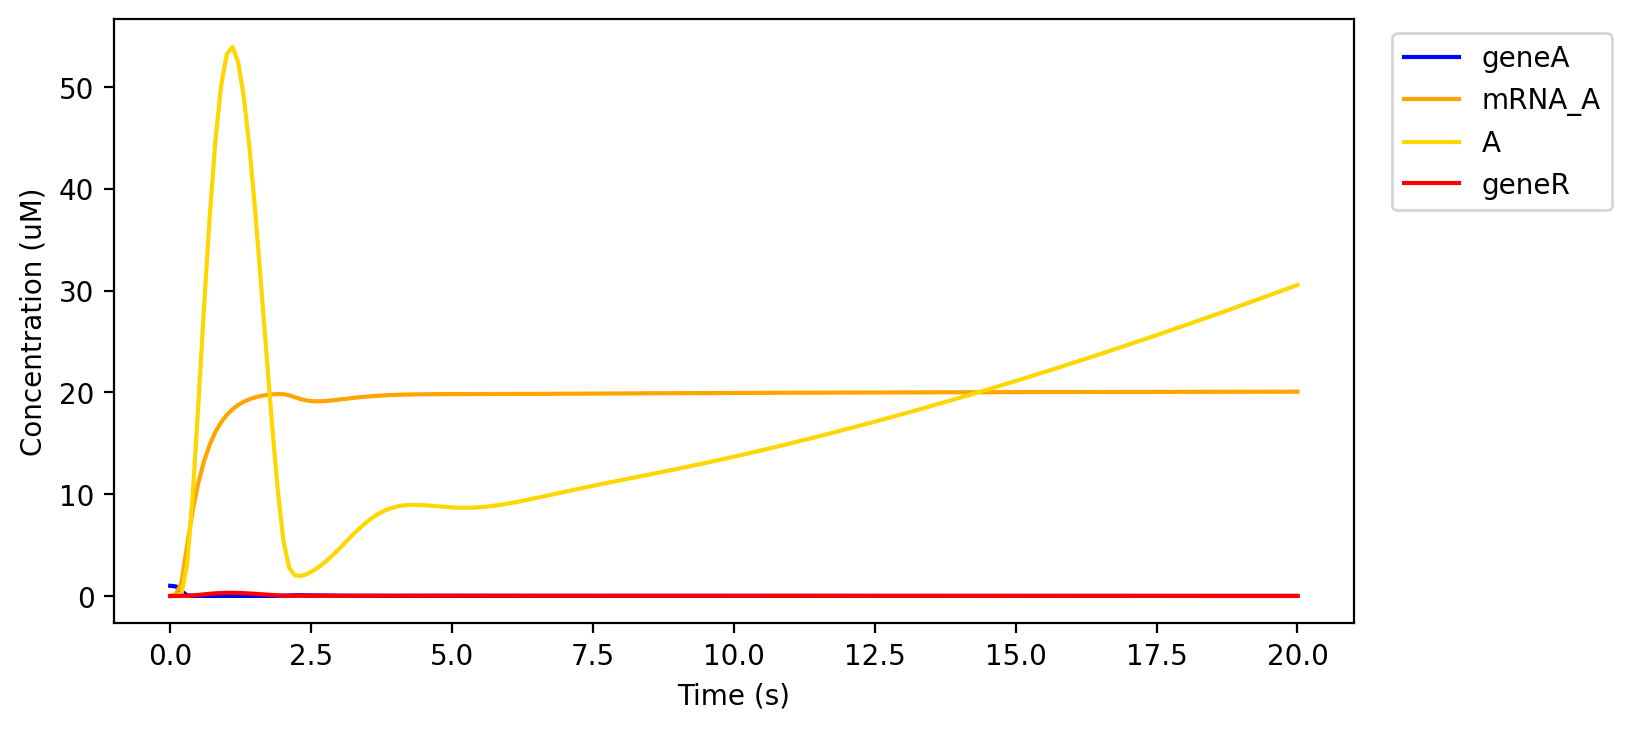

2


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.1123634786302545, 10.762216050392702, 76.92789627335472, 67.66181591629056, 0.08284812877345327, 0.4467013764904685, 123.45659400862627, 25.182871553496316, 19.630099291693572, 30.111582117293054, 53.20578092723854, 13.278732801040322, 1.2634103142464885, 1.90078060811248, 1.9419225277182974, 62.027031064295976]


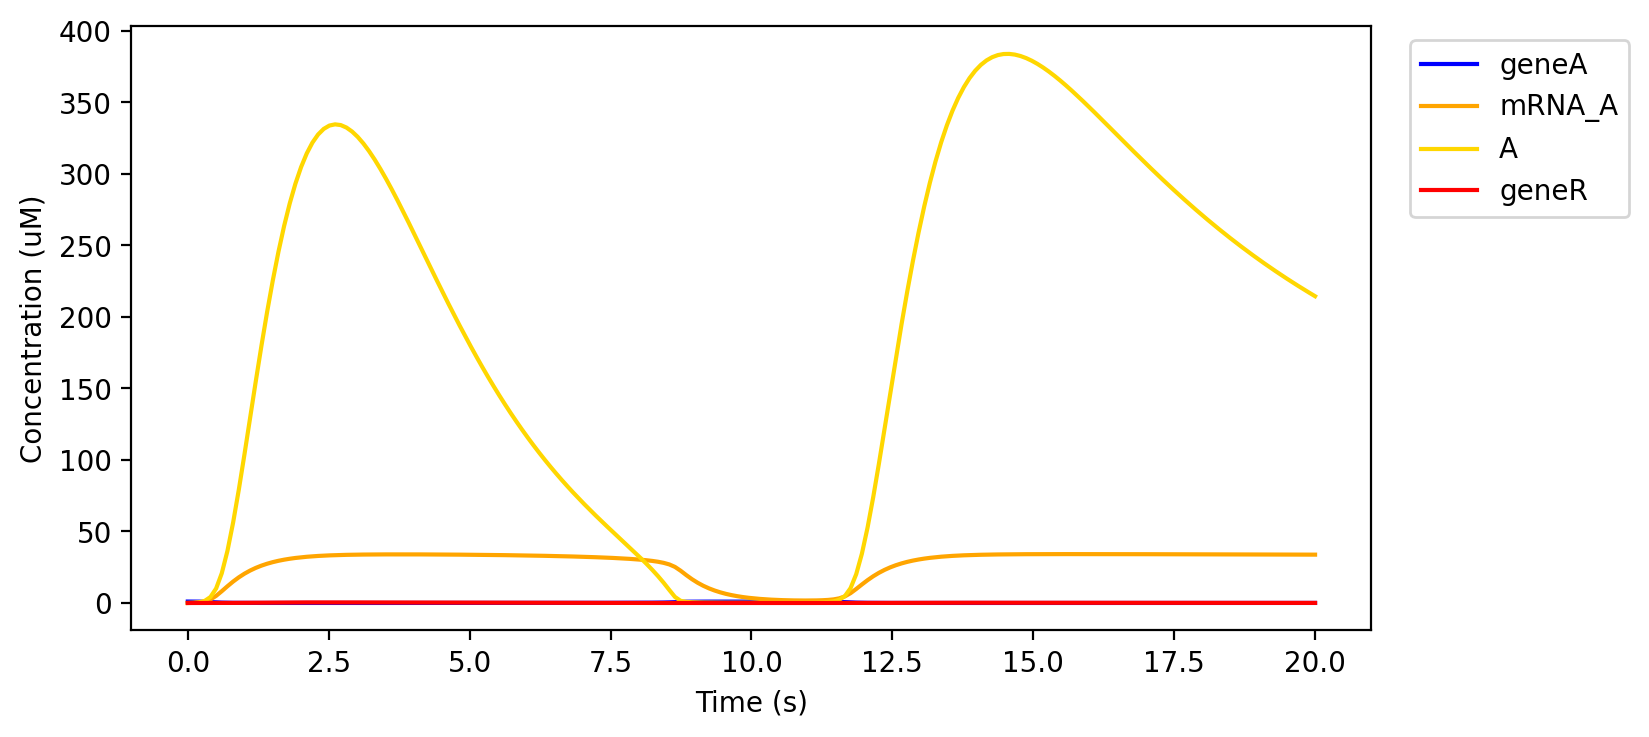

3


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.1123634786302545, 6.797303434704244, 76.92789627335472, 92.87218476286348, 0.06467577750033107, 1.4859931171161842, 331.3885605578123, 33.095662561010336, 100.0, 21.09182326918162, 93.84802173998771, 15.394971375683074, 0.8332417498086435, 3.117882651949164, 1.4452987282976533, 64.04211048562723]


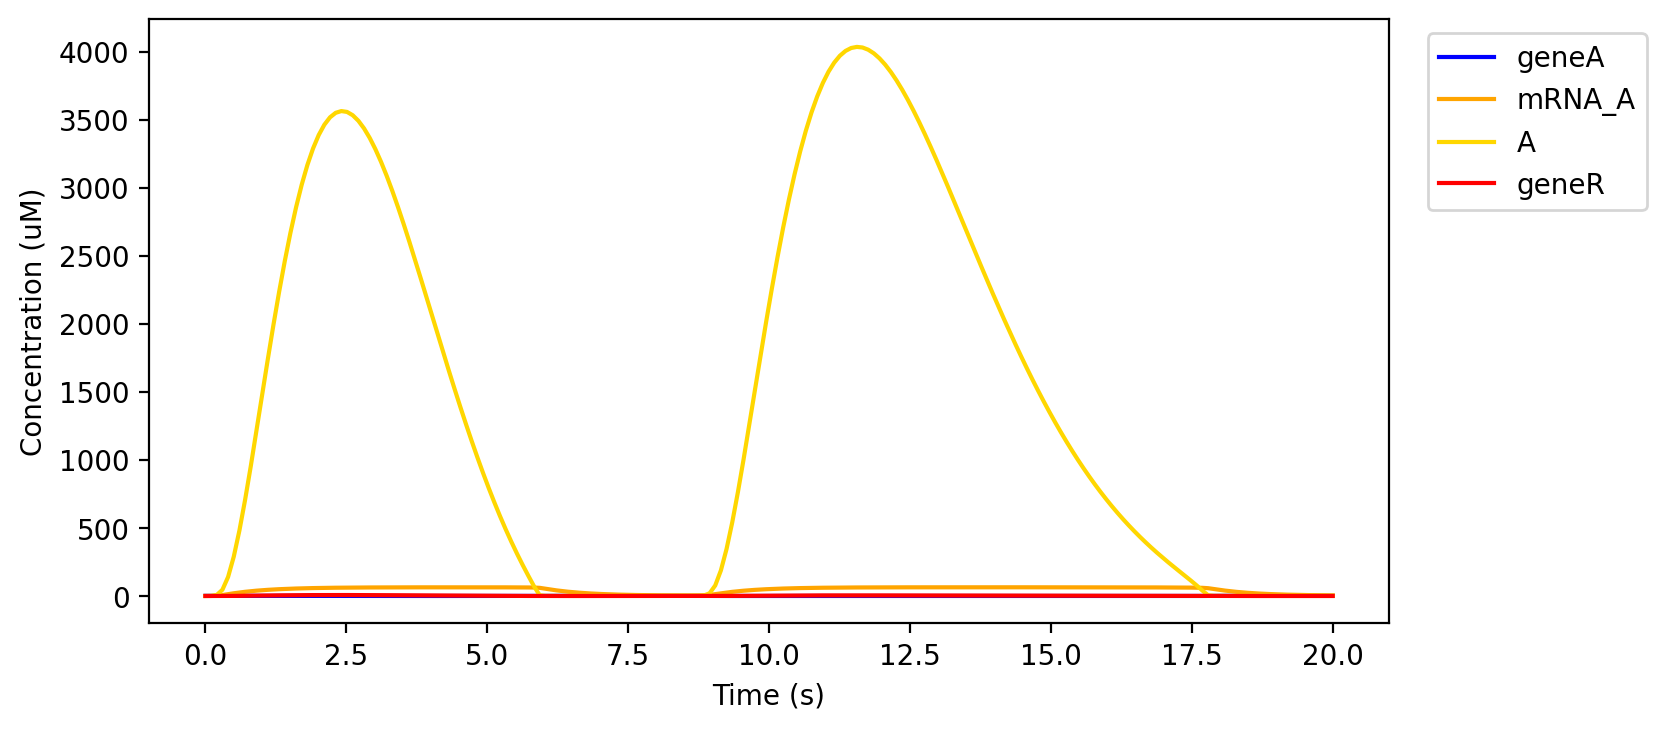

4


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.5364358637821968, 12.101794822998698, 97.84282360491005, 97.96810093299108, 0.08473840292467195, 0.4808182936461071, 142.53390880138016, 87.41359122291163, 100.0, 40.2815574298335, 36.11953348946661, 7.373076377604225, 0.466370452230612, 2.6059257749412, 0.5182887160422366, 46.244845066949054]


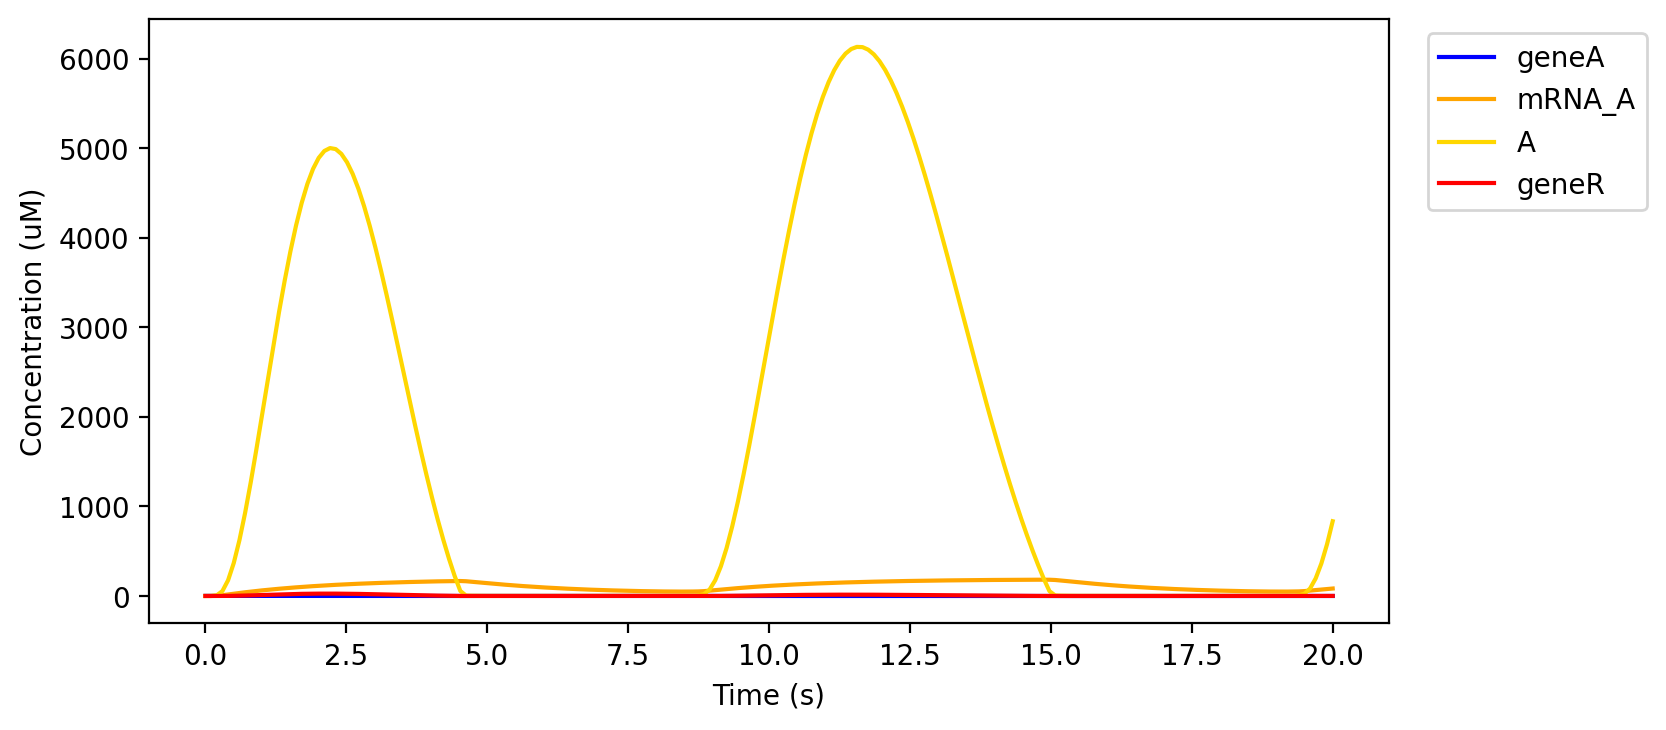

5


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [10]:
filename =  os.path.join(".", "FinalProj1")  
print(filename)  
model = Oscillator(param_values, np.array([k for k in param_values.keys()]), np.array([1,0,0,0,1,0,0,0,0]), mode=1)  #[0,3,0.2,0.3,0,0.9,0,0,0,0,0,0]
solver = Solver(model, name = 'FinalProj1')         
solver.run(filename) 

In [ ]:
# %matplotlib ipympl 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Set up the grid and initial concentrations
N = 100
grid = np.zeros((N, N))
grid[N//2, N//2] = 1

# Define the reaction-diffusion equations
# (these are the classic Gray-Scott equations)
dA = 0.1
dB = 0.05
f = 0.05
k = 0.062

def update(frame):
    global grid

    # Compute the new concentrations using the reaction-diffusion equations
    new_grid = np.zeros_like(grid)
    for i in range(N):
        for j in range(N):
            a = grid[i, j]
            b = 1 - a
            laplacian_a = (
                grid[(i+1)%N, j] + grid[(i-1)%N, j] +
                grid[i, (j+1)%N] + grid[i, (j-1)%N]
            ) / 4 - a
            laplacian_b = (
                grid[(i+1)%N, j] + grid[(i-1)%N, j] +
                grid[i, (j+1)%N] + grid[i, (j-1)%N]
            ) / 4 - b
            new_grid[i, j] = (
                a +
                dA * laplacian_a -
                a * b**2 +
                f * (1 - a)
            )
            grid[i, j] = (
                b +
                dB * laplacian_b +
                a * b**2 -
                (k + f) * b
            )

    # Update the plot
    im.set_data(grid)
    return im

# Set up the figure and animation
fig = plt.figure()
im = plt.imshow(grid, cmap='jet', animated=True)
plt.colorbar()
ani = animation.FuncAnimation(fig, update, frames=100, interval=100)

ani.save('reaction-diffusion.gif', writer='Pillow', fps=30)
plt.show()


: 

In [6]:
!jupyter nbextension install --py ipympl

Installing /Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/ipympl/nbextension -> jupyter-matplotlib
Making directory: /usr/local/share/jupyter/nbextensions/jupyter-matplotlib/
Copying: /Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/ipympl/nbextension/index.js -> /usr/local/share/jupyter/nbextensions/jupyter-matplotlib/index.js
Copying: /Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/ipympl/nbextension/index.js.map -> /usr/local/share/jupyter/nbextensions/jupyter-matplotlib/index.js.map
Copying: /Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/ipympl/nbextension/index.js.LICENSE.txt -> /usr/local/share/jupyter/nbextensions/jupyter-matplotlib/index.js.LICENSE.txt
Copying: /Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/ipympl/nbextension/extension.js -> /usr/local/share/jupyter/nbextensions/jupyter-matplotlib/extension.js
- Validating: OK

    To initialize this nbextension in th

In [ ]:
!jupyter nbextension disable ipympl --py

: 